# Using Enformer Celltyping

This workbook steps through the different use cases for the trained, Enformer Celltyping model.

To begin, download all necessary reference files for Enformer Celltyping by running the following
in the command line from within the downloaded repo - `EnformerCelltyping/`:

```
conda env create -f ./environment/enformer_celltyping.yml &&\
make env &&\
conda activate EnformerCelltyping &&\
pip install -e . &&\
python bin/download_Enformer_Celltyping_dependencies.py
```

This will download:
  1. The saved weights for the trained Enformer Celltyping model (`./enformer_celltyping`)
  2. The hg19/GRCh37 reference genome split by nucleotide, saved as a bigWig file (`./data/dna/`)
  3. The average chromatin accessibility signal for the 104 [EpiMap](http://compbio.mit.edu/epimap/) training cell types (`./data/model_ref`)
  4. The [ENCODE Blacklist](https://www.nature.com/articles/s41598-019-45839-z) regions (`./data/model_ref/`)
  5. The trained [enformer model](https://www.nature.com/articles/s41592-021-01252-x) from Tensorflow Hub (`./data/enformer_model/`)
  6. BigWig Microglia chromatin accessibility signal at 128 base-pair resolution (`./data/demo/`)
  
Some notes on the usage of these in the model:
  * **Enformer Celltyping model** - The model after training regeme outlined in [full_training_recreation.ipynb](https://github.com/neurogenomics/EnformerCelltyping/blob/master/full_training_recreation.ipynb) and in our manuscript.
  * **hg19 genome reference** - Needed to make any predictions by the model, pass the DNA from that genomic region.
  * **average chromatin accessibility** - Used as input to the model along with the cell type specific chromatin accessibility.
  * **ENCODE Blacklist** - These regions can be excluded from predictions.
  * **Trained enformer model** - This model is processed to remove final layers to enable transfer learning in Enformer Celltyping.
  * **Microglia chromatin accessibility signal** - data taken from [Nott et al. 2019](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub=pubmed) which has been processed as discribed in section 1.1 so it is ready for input to Enformer Celltyping. We will use this to demo Enformer Celltyping's functionality


## 1. Predicting with Enformer Celltyping

The first thing we can do with Enformer Celltyping is predict the cell type-specific histone marks for a particular
region of the genome. To make a prediction of the histone mark signal for your cell type/tissue of interest, you need the corresponding chromatin accessibility (ATAC-Seq data).


### 1.1 Processing your cell type-specific chromatin accessibility data

The data needs to be the -log10 p-value signal for every base-pair, in bigWig format. This is an output after peak calling but **note** that this is not the default output type. The easiest way to get this data is to run the [ENCODE ATAC Pipeline](https://github.com/ENCODE-DCC/atac-seq-pipeline) with the raw FASTQ files from your study. Make sure to use the hg19 reference genome as this is the reference genome for which Enformer Celltyping predicts. Once run, the bigWig file with the pooled -log10 p-value should be in the following folder: 

```
./atac/<run-id>/call-macs2_signal_track_pooled/execution/rep.pooled.pval.signal.bigwig
```

Now, this file will be averaged to 25 base-pairs whereas the model takes 128 base-pair averaged chromatin accessibility. To update the file to 128 base-pair averaging, activate the `r_bioc` (`conda activate r_bioc` - this was created with the `mke env` call earlier) and run:

```
Rscript ./bin/avg_bigwig_tracks.R path/to/bigwig/file 128
```

This will create the 128 base-pair averaged bigWig file in the same location as the original with `_128` appended to the name. Now you are ready to pass your data to Enformer Celltyping and get some predictions.

### 1.2 Predicting histone mark signals

To show how to predict there is a chromatin accessibility (ATAC-Seq) bigWig file, averaged at 128 base-pairs for Microglia sourced from [Brain cell type–specific enhancer–promoter interactome maps and disease-risk association](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed). This will be used for demostration purposes.


In [1]:
#first let's sort our data loader

#use the following:
#PROJECT_PATH - path to the EnformerCelltyping repo to get relative paths
from EnformerCelltyping.constants import PROJECT_PATH

#path to the cell type-specific chromatin accessibility bigWig
chrom_access_pth = str(PROJECT_PATH /'data/demo/Nott19_Microglia_128.bigWig')
#give the name of the cell
cell = 'Nott19_Microglia'

#import the data generator which will take care of any preprocessing
from EnformerCelltyping.utils import generate_sample

#data generator class for samples
data_generator = generate_sample(
    cells = {cell:chrom_access_pth}, #should be a dict
    )

2023-02-17 11:38:43.803689: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#load Enformer celltyping model
import tensorflow as tf
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping

#load histone marks from constants so the ordering of predictions is known
from EnformerCelltyping.constants import PRED_HIST_MARKS

hist_marks = PRED_HIST_MARKS

model = Enformer_Celltyping(enf_path=str(PROJECT_PATH / "data/enformer_model"),#path to enformer model
                            use_prebuilt_model=True,
                            enf_celltyping_pth = str(PROJECT_PATH /'EnformerCelltyping'/'enformer_celltyping_weights')
                           )
#compile loaded model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.mean_squared_error,
              #mse for each hist mark
              metrics=['mse'])

2023-02-17 11:44:19.103703: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-17 11:44:19.118624: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-17 11:44:19.118703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (workstation-neurogenomics): /proc/driver/nvidia/version does not exist
2023-02-17 11:44:19.119246: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 11:44:49.722485: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the f

Now let's predict

Let's predict at the TSS of [Iba1/AIF-1](https://grch37.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000204472;r=6:31582961-31584798) Gene

This is a microglia marker gene

Found at Chromosome 6: 31,582,961-31,584,798 hg19

In [3]:
#load data for a specific genomic position
tss = 31_582_961
dna_window = 196_608
chro='chr6'
#we want the TSS centered in the prediction
#pos is the start of the DNA window
strt = tss-(dna_window//2)
end = tss+(dna_window//2)
X = data_generator.load(pos=strt,
                           chro=chro,cell=cell)
print({key:item.shape for key, item in X.items()})

{'dna': TensorShape([1, 196608, 4]), 'chrom_access_lcl': TensorShape([1, 1562]), 'chrom_access_gbl': TensorShape([1, 14592])}


So you can see the data loader has returneda dictionary of tensors containing the DNA sequence for the region (one-hot encoded) (`dna`) along with the local and global chromatin accessibility data for the cell type. The local chromatin accessibility (`chrom_access_lcl`) is the chromatin accessiblity signal for the same region as the DNA whereas the global chromatin accessibility is the chromatin accessibility from the transcriptional start site (3k base-pairs) for all known marker genes taken from [PangloaDB](https://panglaodb.se/) (`chrom_access_gbl`). Both these signals correspond to the arc-sin transformed chromatin accessibility data for the cell type of interest. Enformer Celltyping uses arc-sin transformed signal as a method to deal with differing sequencing depths and other batch effects across studies. The global chromatin accessibility signal is averaged at 250 base-pairs whereas the local chromatin accessibility signal is at 128 base-pairs.

So the model uses the DNA sequence to highlight DNA interactions based on sequence to predict an average histone mark signal. The chromatin accessibility data is jointly used to derive the cell type-specific histone mark signal based on this average. In this manner, the cell type specificity of the model is derived from chromatin accessibility. We include the gobal and local signal so the model can have an understanding of the cell type (global) and the region in which it is trying to predict (local).

Now we can pass this data to our model to predict.

In [4]:
#Now let's predict
pred = model.predict(X)
pred.shape

2023-02-10 08:41:43.264287: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-10 08:41:43.304332: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1996250000 Hz


(1, 896, 6)

So the shape of the output is (1,896,6) matrix where 1 is the number of samples we predicted, 896 is the length of the genomic region we predicted for (where each 1 corresponds to 128 base-pairs) and 6 is the six separate histone marks we predicted for. Let's plot the prediction to view the signals.

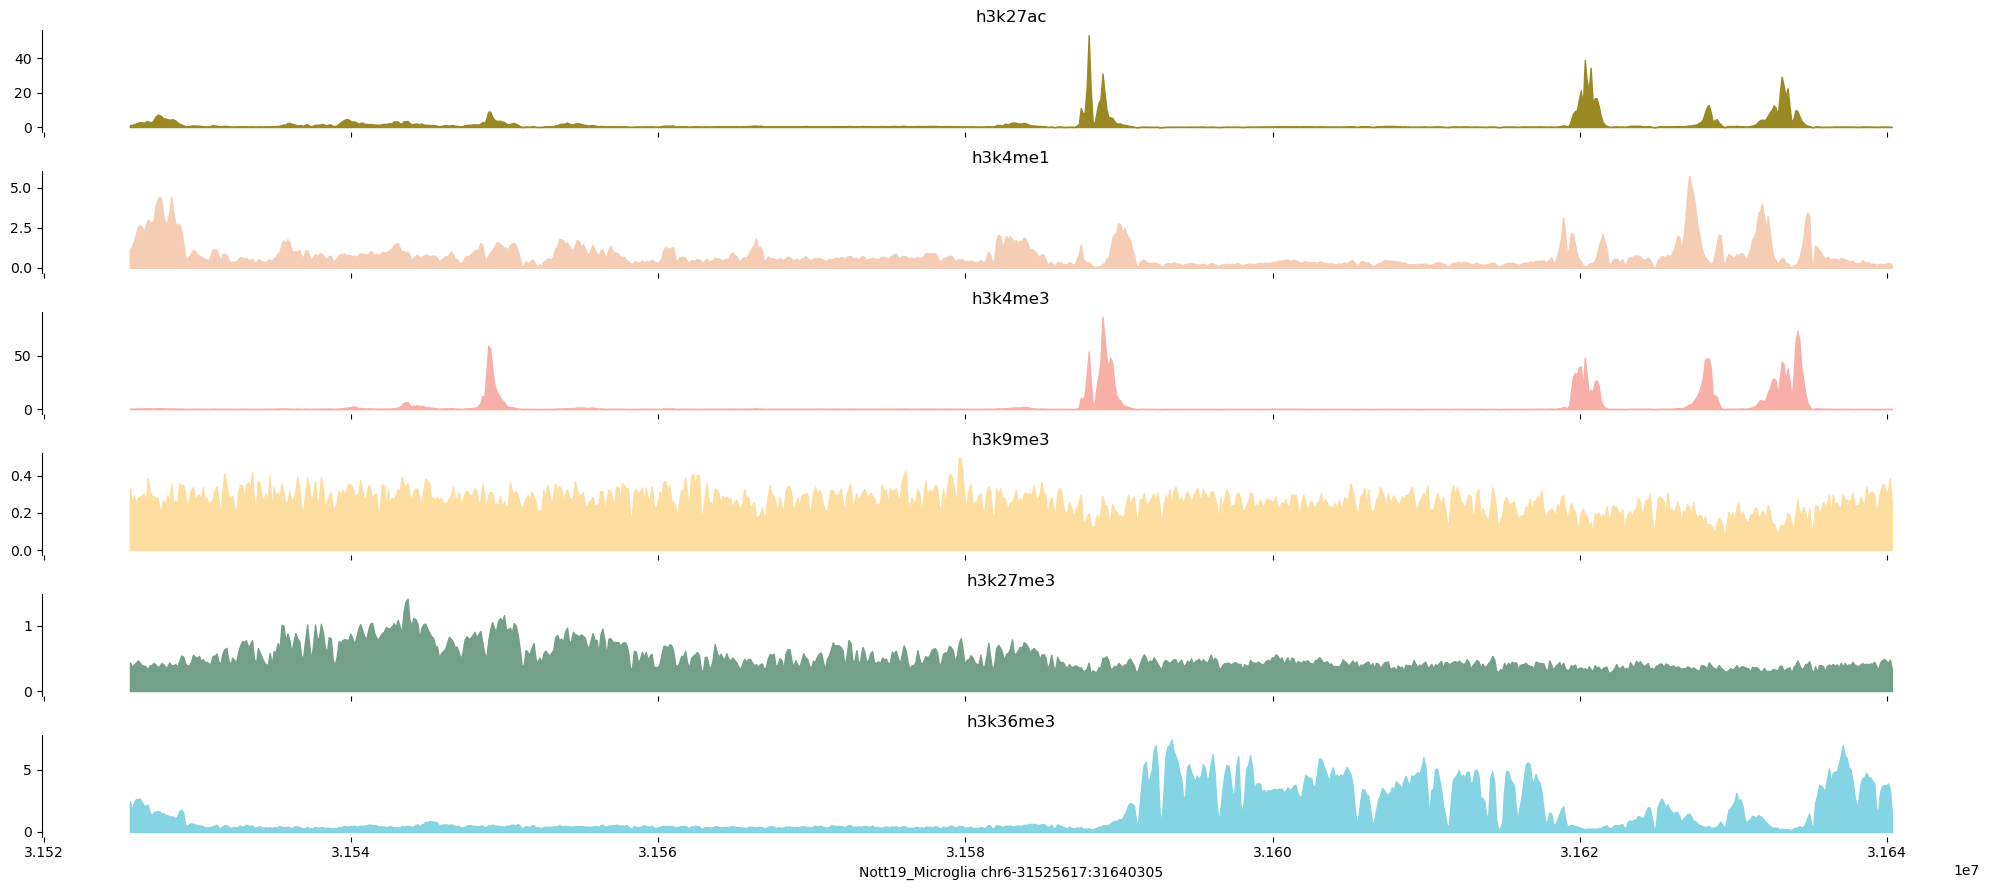

In [5]:
#get order of histone marks in predictions
from EnformerCelltyping.constants import PRED_HIST_MARKS
#make plotting easier
from EnformerCelltyping.utils import plot_signal
    
#make dict with histone mark prediction and name
#get the prediction window, Enformer Celltyping pridicts in a funnel shape
#where it won't predict for every base-pair of the input length
#get bp size of DNA input
from EnformerCelltyping.constants import WINDOW_SIZE_DNA
#use buffer to deal with funnel
buffer = (WINDOW_SIZE_DNA - pred.shape[1]*128)//2
#create interval dict for plotting
interval = {'start':strt+buffer,'end':end-buffer,
            'chro':chro,'cell':cell}
#now plot
plot_signal({i:pred[0,:,ind] for ind,i in enumerate(PRED_HIST_MARKS)},
            interval)

### Predicting entire genome (CHR 1-22)

You may want to predict the entire genome and save the result as a bigWig file (a separate one for each histone mark). This can be done on the command line. See below for the command to use with the EnformerCelltyping conda env to make a biwig for each histone mark for the microglia from [Nott et al., 2019](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed):

```
python ./bin/predict_genome.py -c Nott19_Microglia -p data/demo/Nott19_Microglia_128.bigWig -o ./model_results/predictions/
```

This will predict on a batch of 4 positions at a time, if you have available RAM, increase this batch size by using the -b input paramter which will increase the speed of predictions. Conversely, if you hit memory issues, drop this number.

**Note** this should only really be run with a GPU as it takes **33 hours with a GPU**. The script can be adapted to run in parallel. Also make sure to process your ATAC-seq data as described in section 1.1 before running the above on it.

**Second Note** - if you want to predict in more than one cell type/tissue, I advise precomputing ands saving the DNA embedding by passign it through enformer, this will massively speed up genome-wide predictions for your cell type of interest so pays off if you (eventually) want to look at more than 1 cell type. This does require a substantial amount of disk space (**~240 GB**). To use this approach, first precomute the DNA embeddings with:

```
python ./bin/precompute_dna_embeddings.py 
```

Then use these embeddings when predicting in your cell type of interest with:

```
python ./bin/predict_genome_precomp.py -c Nott19_Microglia -p data/demo/Nott19_Microglia_128.bigWig -o ./model_results/predictions/
```

You can change the DNA Embedding directory with the `-d` parameter.

## 2. Testing Enformer Celltyping's receptive field

Although Enformer Celltyping takes in ~200k of DNA to make it's predictions, it is not guaranteed that a model will pay attention to the full width of the input length (this is especially true for convolutional models as the input size increases). 

We can test Enformer Celltyping's receptive field by passing it random DNA sequences and then permuting the base-pair at different positions to check if the change has any effect on the model's outputted prediction. By using many random sequences of DNA and many random changes of base-pairs, at many locations of the input window, we can get a good idea of how much a position will contribute to the prediction. We can then aggregate this contribution and plot it against the input position that's permutation caused the contribution. That's exactly what the function below does so let's run it on Enformer Celltyping.

This approach is similar in approach to occlusion methods in image analysis where models predictions are linked back to regions of the input image that drove it by systematically excluding groups of pixels of the image and checking the difference in the prediction. The difference is here, we test if a change in certain genomic positions cause any change in the prediciton for the centre of the predicted window, testing how far away genetic variants can be picked up in the models prediction.

In [17]:
from EnformerCelltyping.utils import measure_receptive_field

# Set random seeds so same data used for both
np.random.seed(101)

#increase the number of iterations and number of positions tested to increase accuracy
N_iter= 4
N_pos= 20

ec_data,ec_mut_eff_size = measure_receptive_field(model, seq_length= 196_608,
                                                  N_iter= N_iter,N_pos= N_pos)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [56:27<00:00, 169.37s/it]


/tmp/ipykernel_2213642/323053159.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


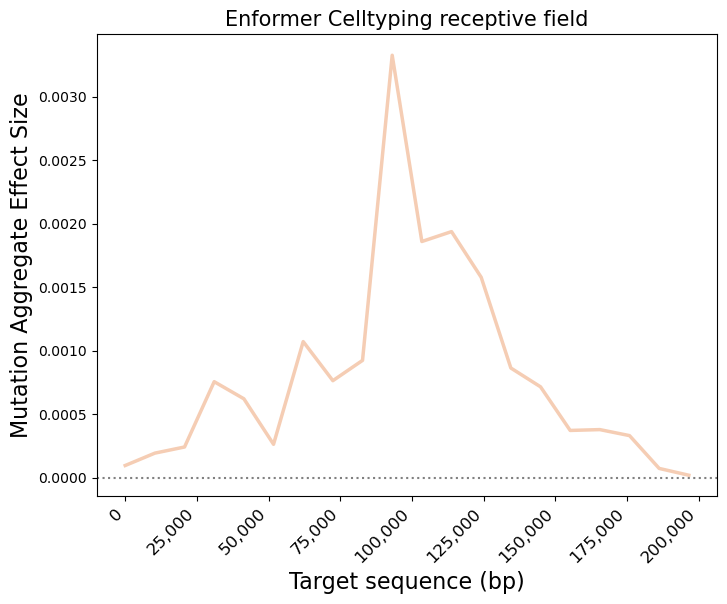

In [41]:
#now let's plot

import matplotlib.pyplot as plt

col = "#F5CDB4"

fig, ax = plt.subplots(figsize=(8, 6))

plt.rc('axes', titlesize=15, labelsize=14)
label_format = '{:,.0f}'

ax.plot(ec_data.keys(),ec_mut_eff_size,
        linewidth=2.5,
        color=col)
ax.set_title(f"Enformer Celltyping receptive field")
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels(
    [label_format.format(x) for x in ticks_loc],
    rotation=45,
    fontsize=12,
    ha="right"
)
ax.set_xlabel('Target sequence (bp)', fontsize=16)
ax.set_ylabel('Mutation Aggregate Effect Size', fontsize=16)
ax.axhline(y=0, color='grey', linestyle='dotted')

We can see even at this low numebr of iterations, that there is a noticable effect of permuting a base-pair at the edge of the ~200k input (look at position 0). You can replciate the receptive field in our manuscript by increasing the `N_iter` and `N_pos` values but note this will take some time to run.

## 3. Visualising Enformer Celltyping's cell type embedding

Enformer Celltyping takes in a global chromatin accessibility signal to have a global representation of a cell type. This information is passed to embedding layers which learns a latent representation of each cell type. This approach is similar to that used in [Avocado](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-01977-6).

As such we can take the weights of the layer to visualise this latent representation and plot it in a 2D space.

### NOTE
This section requires chromatin accessibility data from the 104 training cell types used for the trained Enformer Celltyping model. If you would like to rerun this yourself, see [full_training_recreation.ipynb](https://github.com/neurogenomics/EnformerCelltyping/blob/master/full_training_recreation.ipynb) for instructions for how to download and preprocess the necessary data.

In [3]:
from EnformerCelltyping.constants import (WINDOW_SIZE_GBL_CA,
                                          WINDOW_SIZE_LCL_CA,
                                          ENF_CHANNELS,
                                          ENF_PRED_POS)

n_gbl_factors=25

#Now let's get the index of the weights from the embedding layer
embed_GBLw = model.load_embedding('gbl_embedding')

#now upload these weights to separate layers and get result for passing in DNA from diff cell types
inputs = dict(
        dna= tf.keras.layers.Input(
            shape=(ENF_PRED_POS,ENF_CHANNELS),
            name='dnaInput'
        ),
        #local chrom access embed
        chrom_access_lcl= tf.keras.layers.Input(
            shape=(WINDOW_SIZE_LCL_CA//128,),
            name='ChromAccessLclInput'
        ),
        #global chrom access embed
        chrom_access_gbl= tf.keras.layers.Input(
            shape=(WINDOW_SIZE_GBL_CA//250,),
            name='ChromAccessGblInput'
        )
    )

#Embed global
embedGbl = tf.keras.layers.Embedding(WINDOW_SIZE_GBL_CA//250,
                                     n_gbl_factors,
                                     input_length=1,
                                     name="gbl_embedding")(inputs['chrom_access_gbl'])
#flatten
embedFlat = tf.keras.layers.Flatten(name="flattenGBL")(embedGbl)

#make model
mod_embed = tf.keras.Model(inputs, embedFlat, name = "EmbeddedWeights")

#Update layer weights from model
mod_embed.layers[1].set_weights(embed_GBLw)

In [4]:
#now use a data loader to pass all cell types through the model
#chosen position doesn't matter since it is only the global CA signal we want

#import ids for 104 training and valid samples
from EnformerCelltyping.constants import SAMPLE_NAMES

#data generator class for samples
data_generator = generate_sample(
    cells = SAMPLE_NAMES, #we pass the ID since train/valid samples are referenced in the constants file
    return_y=False #only need CA data
    )

In [8]:
from tqdm import tqdm
import numpy as np
import pandas as pd

vals_embed = []

#any chro and postion is fine since we only want global signal
chro='chr6'
pos=10_000_000
#loop through each train/valid cell type
for ind, cell_i in enumerate(tqdm(SAMPLE_NAMES)):
    X = data_generator.load(pos=pos,
                           chro=chro,cell=cell_i)
    if ind ==0:
        #get enf pred for DNA to pass to Enformer Celltyping Embedding layer
        enf_pred_dna = model.enf.predict_on_batch(X['dna'])
    X['dna'] = enf_pred_dna
    #get emebedding
    vals_embed.append(np.reshape(mod_embed.predict(X),[-1]))
vals_embed = np.array(vals_embed)    

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [10:00<00:00,  5.78s/it]


In [14]:
#Now let's inspect
#first get metdata for cells
from EnformerCelltyping.constants import METADATA_PATH, CELLS

cell_info = pd.read_csv(METADATA_PATH/'cell_info.csv')
#get names for EpiMap ID's
train_valid_sample_names = [CELLS[x] for x in SAMPLE_NAMES]

#Let's visualise with UMAP, need to install it (and scikit-learn):

In [15]:
pip install umap-learn

  Using cached umap-learn-0.5.3.tar.gz (88 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 19.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s eta 0:00:000:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 1.6 MB/s eta 0:00:0000:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=11176384b6c56f977bafe0d9be2e055ddbdbb76cea6e9dbb0a48a6f25fdf5603
  Stored in directory: /home/aemurphy/.cache/pip/wheels/fb/99/10/ed2f3bc57ea29f540470eb43570929e30ae911b2d8353b2ee4
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55496 sha256=5aac5d

In [16]:
#umap only including tissues
#
grouping = np.array(cell_info[cell_info['BSSID'].isin(SAMPLE_NAMES)]['Group'])
cell_type = np.array(cell_info[cell_info['BSSID'].isin(SAMPLE_NAMES)]['Type'])

vals_embed_tissue = vals_embed.copy()
#keep tissue and remove where just one tissue type
rmv = list(set(np.where(cell_type!='tissue')[0].tolist()+
               np.where((grouping=='Spleen')|(grouping=='Other')|
                        (grouping=='Adipose')|(grouping=='Pancreas')|
                        (grouping=='Lung'))[0].tolist()))
keep = np.where((cell_type=='tissue')&(grouping!='Spleen')&
                (grouping!='Other')&(grouping!='Adipose')&
                (grouping!='Pancreas')&(grouping!='Lung'))[0].tolist()
vals_embed_tissue = np.delete(vals_embed_tissue,rmv,axis=0)

import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
#transform data
scaled_X = StandardScaler().fit_transform(vals_embed_tissue)
#embed
embedding_X = reducer.fit_transform(scaled_X)

/home/aemurphy/anaconda3/envs/EnformerCelltyping/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

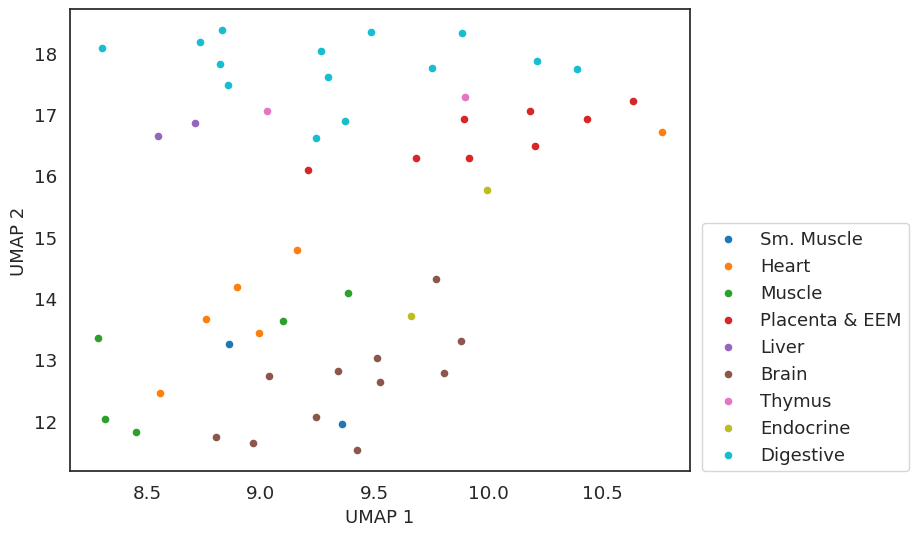

In [20]:
#plot umap
import matplotlib.pyplot as plt
import seaborn as sns
#only colur the tissue as we know these should be similar,
#harder to say for cell lines and cancer
grouping_tiss = grouping[keep]

grouping_unique_tiss = list(set(grouping_tiss))
colors_ = [i for i in sns.color_palette("tab10")]
colors_.pop(7)
sns.set(rc={'figure.figsize':(16, 12)})
sns.set(font_scale = 1.2)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 6))
for g in grouping_unique_tiss:
    ix = np.where(grouping_tiss == g)
    ax.scatter(embedding_X[ix, 0], embedding_X[ix, 1], 
               c = colors_[grouping_unique_tiss.index(g)], 
               label = g, s=20)
ax.legend(prop={'size': 13}, loc=(1.02,0))
ax.set_xlabel('UMAP 1', fontsize = 13)
ax.set_ylabel('UMAP 2', fontsize = 13)

plt.show()

## 4. Predicting SNP effects - in silico mutagenesis

A common task of deep learning models that predict epigenetic signatures or gene expression from DNA sequence is _in silico_ mutagenesis or estimating the effect of a genetic variant of interest on a prediction [ref](https://academic.oup.com/bioinformatics/article-abstract/38/14/3557/6604724?redirectedFrom=fulltext).

Enformer Celltyping can also be used for this task and, taking advantage of it's attention layers and large DNA input window (~200k base-pairs) can predict the effect of mutations in distal enhancers.

The idea is simple, pass DNA sequence with and without the genetic variant to the model and then compare the change in prediction:

![_in silico_ mutagenesis](./in_silico_mut.png)

/home/aemurphy/anaconda3/envs/EnformerCelltyping/lib/python3.9/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)
/home/aemurphy/RDS/project/celltypeai/live/Projects/EnformerCelltyping/EnformerCelltyping/utils.py:2727: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.1f}'.format(x) + 'M' for x in axes.get_yticks()/1_000_000])


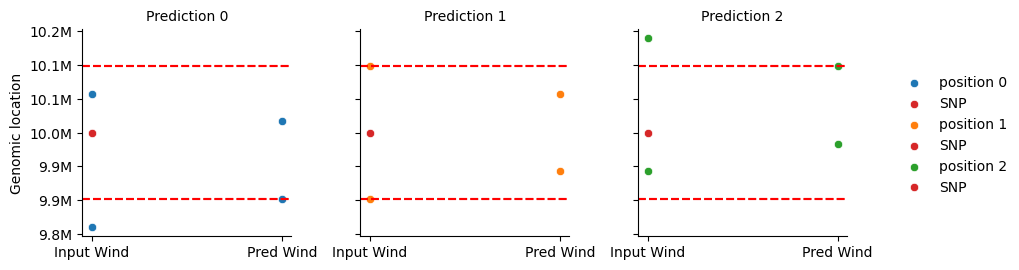

In [5]:
#import functions to make predicting SNP effect easier
from EnformerCelltyping.utils import (create_ref_alt_DNA_window,
                                      plot_snp_dna_window,
                                      predict_snp_effect_sldp
                                      )

dna_strt, snp_pos = create_ref_alt_DNA_window(chro = 'chr6', 
                                              pos = 10_000_001)
#can plot if we want:
plot_snp_dna_window(dna_strt,snp_pos)

`create_ref_alt_DNA_window` calculates the start positions and relative SNP psoitions needed to pass to Enformer Celltyping to predict the effect of a SNP. Note that there are three separate predictions needed to do this. This is contrary to other approaches (like [Enformer](https://www.nature.com/articles/s41592-021-01252-x)) who put the SNP position at the center of the input window only (same as Prediction 1 above). 

By moving the input window relative to the SNP position, we can see the full effect of the SNP across the ~200k base-pairs of the window. This shows the distal effect the SNP as well as the local effect. If we were to just use Prediction 1, we may as well have a model that only takes in 58% of the current input window or ~115k base-pairs rather than ~200k base-pairs.

Now let's predict the effect of the SNP across the full ~200k base-pairs, we have a function to help with this:

In [6]:
#Predict the effective difference of the alternative allele

#Microglia from Nott et al., 2019
cell = 'Nott19_Microglia'

#use the following:
#PROJECT_PATH - path to the EnformerCelltyping repo to get relative paths
from EnformerCelltyping.constants import PROJECT_PATH

#path to the cell type-specific chromatin accessibility bigWig
chrom_access_pth = str(PROJECT_PATH /'data/demo/Nott19_Microglia_128.bigWig')
#give the name of the cell
cell = 'Nott19_Microglia'

#import the data generator which will take care of any preprocessing
from EnformerCelltyping.utils import generate_sample

#data generator class for samples
data_generator = generate_sample(
    cells = {cell:chrom_access_pth}, #should be a dict
    #get the reverse complement and random shift so difference can be aggreated across these
    #too to make the prediction more robust
    reverse_complement = True, 
    rand_seq_shift = True,
    rtn_rand_seq_shift_amt = True #need to return this values so the same value can be used for ref and alt
    )

# rs34487851 associated with neuropathologic traits of Alzheimer's disease -
# https://pubmed.ncbi.nlm.nih.gov/29458411/
# rs34487851 is in ECRG4 which encodes a peptide hormone that is involved in NFT formation, 
# age-related senescence of precursor cells in the CNS and activation of microglia - 
# https://pubmed.ncbi.nlm.nih.gov/33815092/

#pred across full 200k - pass in SNP position and chromosome
dna_strt, snp_pos = create_ref_alt_DNA_window(chro = 'chr2', 
                                              pos = 106_642_554)
#aggregate effect
agg_eff = predict_snp_effect_sldp(model=model,
                                  alt='A',cell = cell, 
                                  chro='chr2',
                                  dna_strt=dna_strt, snp_pos=snp_pos,
                                  data_generator = data_generator,
                                  effect_mode = 'sum')
agg_eff

array([0.0872421 , 0.03210342, 0.06769571, 0.0386596 , 0.05117837,
       0.12756288], dtype=float32)

This is the sum aggreated effect of the SNP across the full 200k base-pairs for each of the six histone marks. We can also plot the signal with and without the SNP to understand where the effect is most prominent.

In [8]:
#plot prediction where SNP centered
#don't need reverse compliment or random perm
data_generator.reverse_complement = False
data_generator.rand_seq_shift = False
data_generator.rtn_rand_seq_shift_amt = False

X_ref = data_generator.load(pos=dna_strt[1],
                            chro='chr2',cell=cell)

X_alt = data_generator.load(pos=dna_strt[1],
                            chro='chr2',cell=cell,
                            snp_base='A',snp_pos=snp_pos[1])
pred_ref = model.predict(X_ref)
pred_alt = model.predict(X_alt)
pred_diff = pred_ref - pred_alt

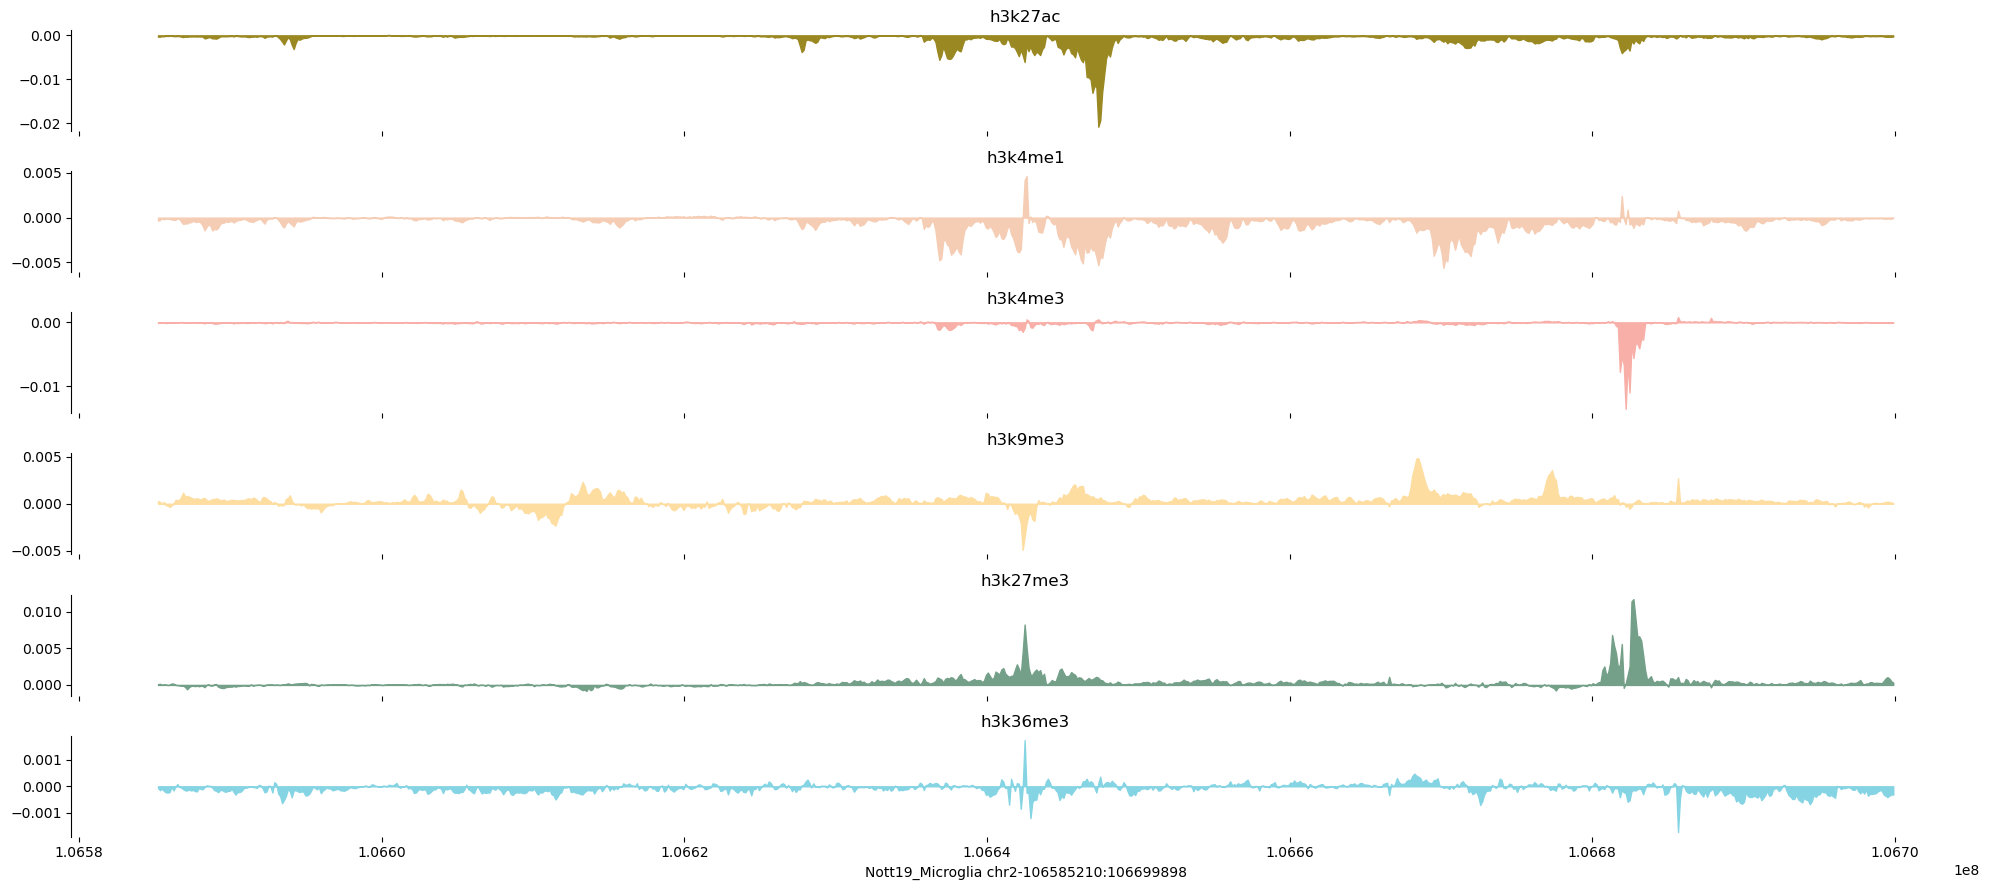

In [11]:
from EnformerCelltyping.constants import PRED_HIST_MARKS
from EnformerCelltyping.utils import plot_signal
    
#make dict with histone mark prediction and name
#get the prediction window, Enformer Celltyping pridicts in a funnel shape
#where it won't predict for every base-pair of the input length
#get bp size of DNA input
from EnformerCelltyping.constants import WINDOW_SIZE_DNA
#use buffer to deal with funnel
buffer = (WINDOW_SIZE_DNA - pred_diff.shape[1]*128)//2
#create interval dict for plotting
interval = {'start':dna_strt[1]+buffer,'end':dna_strt[1]+WINDOW_SIZE_DNA-buffer,
            'chro':'chr2','cell':cell}
#now plot
plot_signal({i:pred_diff[0,:,ind] for ind,i in enumerate(PRED_HIST_MARKS)},
            interval)

We can see H3K27ac shows a large decrease in binding around the SNP site.

We used _in silico_ mutagenesis predictions from Enformer Celltyping along with [SLDP](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6202062/) to understand the genome-wide, directional effect of genetic variants that relate to a certain phenotype on histone mark binding. The code to run the analysis once the genetic variant effect predicitons have been made (like above) can be found here: `./bin/run_sldp.py`. See our manuscript for more details and our use cases.